<div class="frontmatter text-center">
<h1>Geospatial Data Science</h1>
<h2>Exam project code</h2>
<h3>IT University of Copenhagen, Spring 2022</h3>
<h3>Group: Nina Sand Horup & Ida Thrane</h3>
</div>

In [40]:
# import libraries needed
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd

%matplotlib inline
ox.__version__

'1.0.1'

In [322]:
from shapely.geometry import Point, Polygon

In [27]:
# libraries for plotting
import matplotlib.pyplot as plt
import numpy as np


## Input parameters for user

In [4]:
current_position = "Jagtvej 119, Copenhagen" # Could in practice just come from a GPS location

## Import area

In [8]:
%%time
# Import area from address using radius in meters
G = ox.graph_from_address(
    address=current_position,
    dist=2500,
    dist_type="network",
    network_type="all",
    simplify = True
)

CPU times: user 16.7 s, sys: 82.5 ms, total: 16.8 s
Wall time: 16.8 s


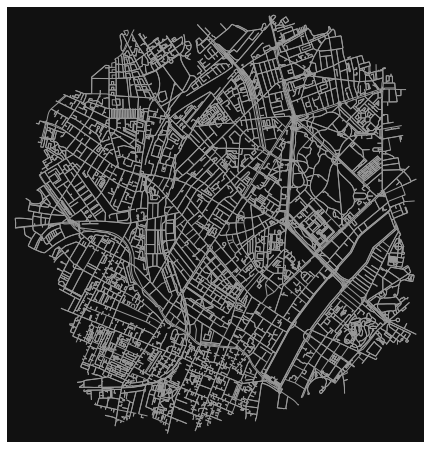

In [12]:
fig, ax = ox.plot_graph(G, node_size=0);

In [13]:
%%time
# We can simplify the graph further by converting to a non-directed. 
# Since the app assumes that the user is on foot (or at least on bike), the one-way roads 
# are not that important

U = ox.utils_graph.get_undirected(G) # U is the non-directed graph.

# Note that this takes extra time - does it help us later on?

CPU times: user 8.56 s, sys: 314 ms, total: 8.88 s
Wall time: 8.9 s


# Getting some destinations

In [408]:
# Here I have just a random list of some points

orig_coord = [55.6974030, 12.5513320]
dest_coord_list = [(55.6915237, 12.5488367), (55.6935237, 12.5478367), (55.6995237, 12.5528367)]



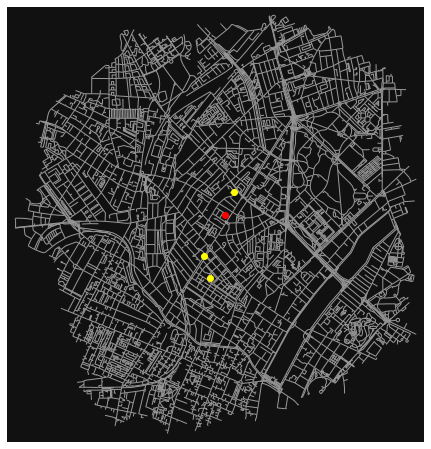

In [409]:
# Let's quickly plot the destinations
fig, ax = ox.plot_graph(U, node_size=0, show=False, close=False);

# Normally osmnx will instantly display the plot, so we set show to be false
# Osmnx will also by default close the plot after showing, sp we set close to false so we can keep the plot for the scatters

ax.scatter(orig_coord[1], orig_coord[0], c='red')
ax.scatter(dest_coord_list[0][1], dest_coord_list[0][0], c='yellow')
ax.scatter(dest_coord_list[1][1], dest_coord_list[1][0], c='yellow')
ax.scatter(dest_coord_list[2][1], dest_coord_list[2][0], c='yellow')

plt.show()

## Converting destinations to actual nodes

We want to turn our geocoordinates of location A into an OSM ID? Ideally, we would be using `osmnx.distance.nearest_nodes`. However, our docker is running an outdated OSMnx version where this function does not work (and its predecessor, ` get_nearest_node`, is deprecated). A possible, neither efficient nor elegant but enough-for-our-purposes workaround is to look for the node that minimizes euclidean distance to location A. 

Note that we still want to plot the destionation at its actual location to ensure that the user is not confused.

In [436]:
nodes = ox.utils_graph.graph_to_gdfs(U, nodes=True, edges=False, node_geometry=True)


# Which OSMIDs do these nodes correspond to, now that we have "simplified" the graph?
# Workaround to use instead of osmnx.distance.nearest_nodes (unavailable in our docker image): 
# https://osmnx.readthedocs.io/en/stable/osmnx.html?highlight=digraph#osmnx.distance.nearest_nodes
# here the geodataframe comes in handy for the apply functions:

# Note that these functions are heavily inspired from the exercise 8 solutions

def get_nearest_node(input_coordinate, nodes_gdf):
    distance = nodes_gdf.apply(lambda x: np.sqrt((x.y - input_coordinate[0])**2 + (x.x - input_coordinate[1])**2) , axis = 1)
    output = distance.idxmin()
    return output


def get_nearest_nodes(input_coordinates, nodes_gdf):
    output = []
    for i in range(len(input_coordinates)):
        distances = nodes_gdf.apply(lambda x: np.sqrt((x.y - input_coordinates[i][0])**2 + (x.x - input_coordinates[i][1])**2) , axis = 1)
        nearest_node = distances.idxmin()
        output.append(nearest_node)
    return output

orig_id = get_nearest_node(orig_coord, nodes)
dest_ids = get_nearest_nodes(dest_coord_list, nodes)




In [427]:
all_nodes = dest_ids + [orig_id]


In [428]:
# create node weights
w = [50 if node in all_nodes else 0 for node in U.nodes]
#nx.set_node_attributes(U, w, 'weight')

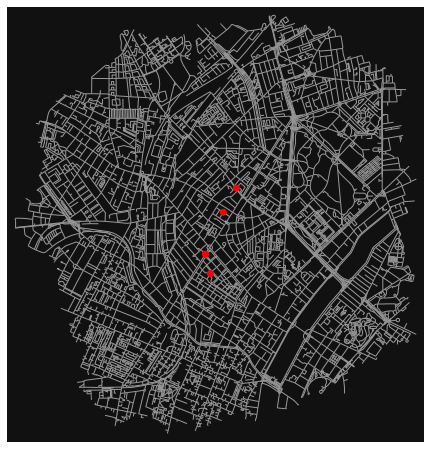

In [429]:
# We plot the nodes which minimizes the distance to the coordinates to check that the method works
fig, ax = ox.plot_graph(U, node_size=w, node_color = 'red');


# Calculating the route

In [430]:
route1 = ox.shortest_path(U, orig_id, dest_ids[0], weight="length")
route2 = ox.shortest_path(U, dest_ids[0], dest_ids[1], weight="length")
route3 = ox.shortest_path(U, dest_ids[1], dest_ids[2], weight="length")

routes = [route1, route2, route3]

In [431]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route1, "length")))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route2, "length")))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(U, route3, "length")))

print("The total route is", route1_length + route2_length + route3_length, "meters.")

The total route is 2042 meters.


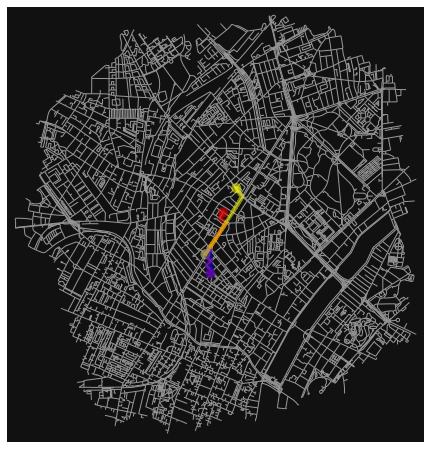

In [432]:
fig, ax = ox.plot_graph_routes(U, routes, route_colors=["red", "blue", "yellow"], node_size=0)


## Adding alternative edge attributes

In order to create nicer routes, we create route attributes which encourage the algorithm to choose routes based on other things than just the length of the route. 

We choose to use the following attributes:

- What is the primary use of the road
- What is the speed limit
- Is the edge in a green area?
- Is the edge near water?

In [434]:
## Here we just get an overview of the keys which exists in the edge data
total_dict = []

for u,v,key,data in U.edges(keys = True, data = True):
    total_dict.append(data)

    
from itertools import chain
  
# Function to print all unique keys present in a list of dictionaries
def UniqueKeys(arr):
  
    # Stores the list of unique keys
    res = list(set(chain.from_iterable(sub.keys() for sub in arr)))
  
    # Print the list
    print(str(res))

print("List of all possible keys in the edges we have avaiable in the current data set:\n")
UniqueKeys(total_dict)


List of all possible keys in the edges we have avaiable in the current data set:

['park_gain', 'lanes', 'junction', 'bridge', 'access', 'test_cost', 'oneway', 'speed_cost', 'ref', 'osmid', 'highway_cost', 'speed_cost_test', 'geometry', 'maxspeed', 'width', 'name', 'tunnel', 'nature_gain', 'service', 'use_cost', 'length', 'highway', 'from', 'to']


### Road use cost

Adding cost which takes into account the use of the road

In [435]:
# Here we look at the possible uses the edges can have, so we get to know our data better

highway_types = []

for u, v, key, data in U.edges(keys=True, data=True): 
    highway_types.append(str(data["highway"]))

highway_list = set(highway_types)
highway_list

{"['cycleway', 'path']",
 "['cycleway', 'residential']",
 "['cycleway', 'service']",
 "['footway', 'cycleway']",
 "['footway', 'living_street']",
 "['footway', 'path']",
 "['footway', 'residential', 'service']",
 "['footway', 'residential']",
 "['footway', 'service']",
 "['footway', 'steps', 'cycleway']",
 "['footway', 'steps', 'path']",
 "['footway', 'steps', 'residential']",
 "['footway', 'steps', 'service', 'path']",
 "['footway', 'steps', 'service']",
 "['footway', 'steps']",
 "['path', 'living_street']",
 "['pedestrian', 'path']",
 "['pedestrian', 'residential', 'path']",
 "['pedestrian', 'residential']",
 "['residential', 'living_street']",
 "['residential', 'path']",
 "['residential', 'service']",
 "['service', 'living_street']",
 "['service', 'path']",
 "['steps', 'path']",
 "['steps', 'residential']",
 "['steps', 'service', 'path']",
 "['steps', 'service']",
 "['track', 'residential']",
 "['unclassified', 'service']",
 'cycleway',
 'elevator',
 'footway',
 'living_street',
 'p

The roads we want to avoid are: tertiary, tertiary_link, primary

In [357]:
# Let's make a function for applying the cost of the road use

# Note: this code is heavily inspired from the exercise 8 solutions

def apply_road_use_cost(G, name_of_cost):
    for edge in G.edges:
        if ("primary" in G.edges[edge]["highway"]) or ("tertiary" in G.edges[edge]["highway"]) or ("tertiary_link" in G.edges[edge]["highway"]):
            G.edges[edge][name_of_cost] = G.edges[edge]["length"] * 2
        else:
            G.edges[edge][name_of_cost] = 0

In [358]:
# Let's try to apply it using the function

apply_road_use_cost(U, "use_cost")

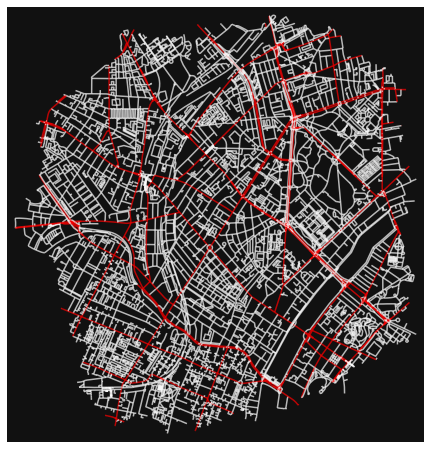

In [360]:
# Let's plot where the highway_cost is over 0 (after applying it)

highway_cost_applied = ["r" if data["use_cost"] > 0 else "w" for u, v, key, data in U.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(U, node_size=0, edge_color=highway_cost_applied, edge_linewidth=1.5, edge_alpha=0.7)


### Road speed cost

We add an extra cost to roads which scale with the speed limit. The reason we do this, is that the road use cost mostly targets the biggest roads, and in this way we can also target medium roads. But the cost will be smaller now than in the road use cost.

We found that the difficult part here was that sometime the max_speed is listed as a list. This is probably due to the fact that OSMnx sinplifies the network, and that some edge attributes can be concatenated into a list if they are different. We choose to just use the biggest value in the list as the ground truth. 

This is taken care of in our road speed cost function.

In [361]:
# Let's make a function instead

def apply_speed_cost(G, name_of_cost):
    for edge in U.edges:
        if "maxspeed" in U.edges[edge]:
            if (type(U.edges[edge]["maxspeed"]) == list): # Here we take the biggest value, if more than one is listed
                float_list = [float(i) for i in U.edges[edge]["maxspeed"]]
                U.edges[edge][name_of_cost] = max(float_list)
            else: 
                U.edges[edge][name_of_cost] = float(U.edges[edge]["maxspeed"])
        else:
            U.edges[edge][name_of_cost] = 0

In [362]:
# Let's use the function

apply_speed_cost(U, "speed_cost")

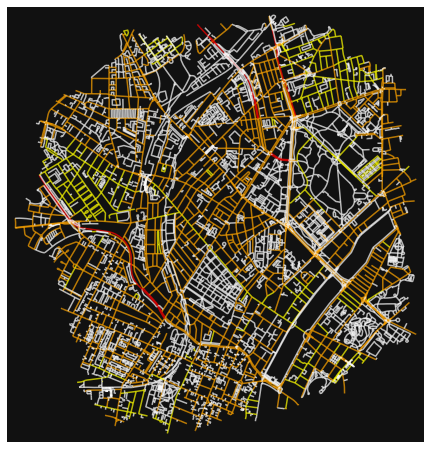

In [364]:
# Let's plot where the speed_cost is over 0 (after applying it)

speed_cost_applied = ["yellow" if (data["speed_cost"] > 0 and data["speed_cost"] < 50) else "orange" if data["speed_cost"] == 50 else "red" if data["speed_cost"] > 50 else "w" for u, v, key, data in U.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(U, node_size=0, edge_color=speed_cost_applied, edge_linewidth=1.5, edge_alpha=0.7)


### Lower cost for green areas



In [392]:
# Get parks and cemetaries
parks = ox.geometries_from_point((55.6935280, 12.5489348), tags = {"leisure": "park", "landuse": "cemetery"}, dist=2500)


<AxesSubplot:>

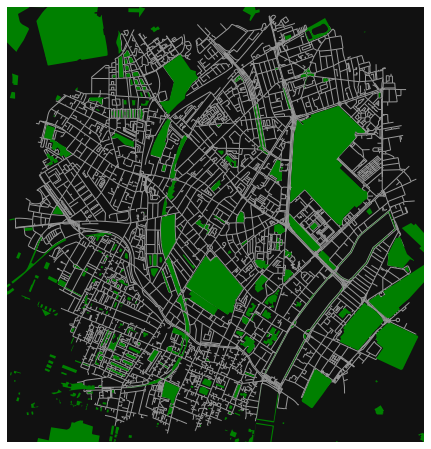

In [393]:
# Let's quickly plot the destinations
fig, ax = ox.plot_graph(U, node_size=0, show=False, close=False);

parks.plot(color="green", linewidth=1, ax=ax)

In [403]:
def apply_gain_to_edges_in_polygons(G, geometries, name_of_gain):
    polygons = geometries['geometry']
    
    nodes_in_polygons = []
    
    # Find nodes in polygons with within function from shapely
    
    for node, data in G.nodes(data = True):
        coord = Point(data["x"], data["y"])
        for poly in polygons:
            if coord.within(poly):
                nodes_in_polygons.append(node)
    
    # Apply edge weight to edges with ends in any of these nodes
    for edge in G.edges:
        if (edge[0] in nodes_in_polygons) or (edge[1] in nodes_in_polygons): 
            G.edges[edge][name_of_gain] = - 2 *  G.edges[edge]["length"]
        else: 
            G.edges[edge][name_of_gain] = 0

In [404]:
apply_gain_to_edges_in_polygons(U, parks, "park_gain")

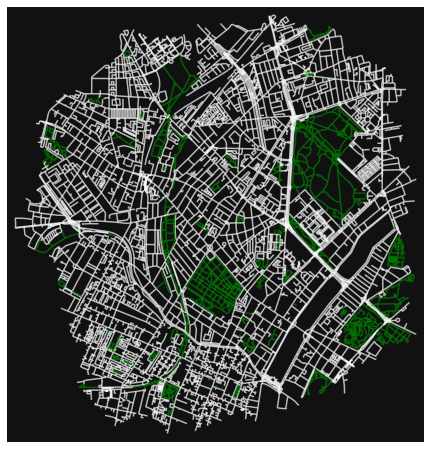

In [406]:
# Let's plot the park gain

park_gain_applied = ["green" if data["park_gain"] < 0 else "w" for u, v, key, data in U.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(U, node_size=0, edge_color=park_gain_applied, edge_linewidth=1.5, edge_alpha=0.7)


### Lower cost for water areas

In [ ]:
water_tags = {"waterway": ["riverbank", "canal", "dock"],
        "water": ["river", "canal", "reservoir"],
        "natural": ["bay", "water"],
        "place": ["sea", "ocean"]}
water = ox.geometries_from_point((55.6935280, 12.5489348), tags = water_tags, dist=2500)

In [ ]:
# Do some stuff here

In [363]:
# Look at edge attributes

for u, v, key, data in U.edges(keys=True, data=True): 
    print(data)

{'osmid': 743336518, 'oneway': False, 'lanes': '4', 'name': 'Tagensvej', 'highway': 'tertiary', 'maxspeed': '50', 'length': 17.55, 'from': 3835639402, 'to': 125442, 'geometry': <shapely.geometry.linestring.LineString object at 0x7ff33576a7c0>, 'highway_cost': 35.1, 'speed_cost': 50.0, 'nature_gain': 0, 'use_cost': 35.1, 'test_cost': 35.1, 'speed_cost_test': 50.0}
{'osmid': [455570576, 455570571], 'oneway': True, 'lanes': ['2', '3'], 'ref': 'O2', 'name': 'Tuborgvej', 'highway': 'primary', 'maxspeed': '50', 'length': 111.036, 'geometry': <shapely.geometry.linestring.LineString object at 0x7ff315592fd0>, 'from': 125442, 'to': 26237008, 'highway_cost': 222.072, 'speed_cost': 50.0, 'nature_gain': 0, 'use_cost': 222.072, 'test_cost': 222.072, 'speed_cost_test': 50.0}
{'osmid': 742654119, 'oneway': False, 'lanes': '4', 'name': 'Tagensvej', 'highway': 'tertiary', 'maxspeed': '50', 'length': 41.397999999999996, 'geometry': <shapely.geometry.linestring.LineString object at 0x7ff332131790>, 'from

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



plot_path func from: 

https://towardsdatascience.com/find-and-plot-your-optimal-path-using-plotly-and-networkx-in-python-17e75387b873


In [ ]:
def plot_path(lat, long, origin_point, destination_point):
    
    """
    Given a list of latitudes and longitudes, origin 
    and destination point, plots a path on a map
    
    Parameters
    ----------
    lat, long: list of latitudes and longitudes
    origin_point, destination_point: co-ordinates of origin
    and destination
    Returns
    -------
    Nothing. Only shows the map.
    """
    # adding the lines joining the nodes
    fig = go.Figure(go.Scattermapbox(
        name = "Path",
        mode = "lines",
        lon = long,
        lat = lat,
        marker = {'size': 10},
        line = dict(width = 4.5, color = 'blue')))
    # adding source marker
    fig.add_trace(go.Scattermapbox(
        name = "Source",
        mode = "markers",
        lon = [origin_point[1]],
        lat = [origin_point[0]],
        marker = {'size': 12, 'color':"red"}))
     
    # adding destination marker
    fig.add_trace(go.Scattermapbox(
        name = "Destination",
        mode = "markers",
        lon = [destination_point[1]],
        lat = [destination_point[0]],
        marker = {'size': 12, 'color':'green'}))
    
    # getting center for plots:
    lat_center = np.mean(lat)
    long_center = np.mean(long)
    # defining the layout using mapbox_style
    fig.update_layout(mapbox_style="stamen-terrain",
        mapbox_center_lat = 30, mapbox_center_lon=-80)
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                      mapbox = {
                          'center': {'lat': lat_center, 
                          'lon': long_center},
                          'zoom': 13})
    fig.show()